In [138]:
!pip install python-louvain
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import community as community_louvain
from collections import defaultdict
from collections import Counter

import matplotlib.colors as mcolors



[notice] A new release of pip is available: 24.1.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [121]:

def loadGraph(filename):
    G = nx.read_gexf(filename)
    return G
    

In [122]:
# Plot in-degree and out-degree distributions
def plot_degree_distribution_directed(G):
    """
    Plot the in-degree and out-degree distributions of a directed graph.

    Parameters:
        G (networkx.DiGraph): The input directed graph.
    """
    in_degrees = [deg for _, deg in G.in_degree()]
    out_degrees = [deg for _, deg in G.out_degree()]

    # In-degree distribution
    in_degree_counts = Counter(in_degrees)
    x_in, y_in = zip(*sorted(in_degree_counts.items()))
    y_in = [count / G.number_of_nodes() for count in y_in]

    plt.figure(figsize=(8, 6))
    plt.bar(x_in, y_in, width=0.8, color='r', alpha=0.7, edgecolor='k', label='In-degree')
    plt.title('In-degree Distribution', fontsize=14)
    plt.xlabel('Degree', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    # Out-degree distribution
    out_degree_counts = Counter(out_degrees)
    x_out, y_out = zip(*sorted(out_degree_counts.items()))
    y_out = [count / G.number_of_nodes() for count in y_out]

    plt.figure(figsize=(8, 6))
    plt.bar(x_out, y_out, width=0.8, color='b', alpha=0.7, edgecolor='k', label='Out-degree')
    plt.title('Out-degree Distribution', fontsize=14)
    plt.xlabel('Degree', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    return {'in_degree': dict(in_degree_counts), 'out_degree': dict(out_degree_counts)}


In [123]:
# Plot size of giant component versus node removal
def plot_giant_component_vs_node_removal_directed(G, removal_strategy="random", title="Random Failures"):
    """
    Plots the size of the largest strongly connected component vs the fraction of nodes removed.

    Parameters:
        G (networkx.DiGraph): The input directed graph.
        removal_strategy (str): The strategy for node removal ('random' or 'degree').
    """
    G = G.copy()
    num_nodes = G.number_of_nodes()

    fractions_removed = []
    giant_component_sizes = []

    if removal_strategy == "degree":
        nodes = sorted(G.out_degree, key=lambda x: x[1], reverse=True)
        nodes = [node for node, _ in nodes]
    elif removal_strategy == "random":
        nodes = list(G.nodes)
        random.shuffle(nodes)
    else:
        raise ValueError("Invalid removal strategy. Choose 'random' or 'degree'.")

    for i, node in enumerate(nodes):
        G.remove_node(node)
        largest_scc = max(nx.strongly_connected_components(G), key=len, default=set())
        fractions_removed.append((i + 1) / num_nodes)
        giant_component_sizes.append(len(largest_scc) / num_nodes)

    plt.figure(figsize=(8, 6))
    plt.plot(fractions_removed, giant_component_sizes, label=f"Strategy: {removal_strategy}")
    plt.title(title, fontsize=14)
    plt.xlabel("Fraction of Nodes Removed", fontsize=12)
    plt.ylabel("Size of Largest SCC", fontsize=12)
    plt.grid(alpha=0.7)
    plt.legend(fontsize=10)
    plt.show()


In [124]:
def detect_communities(G):
    """
    Detects communities in an undirected graph using the Louvain algorithm.

    Parameters:
        G (networkx.Graph): The input graph.

    Returns:
        dict: A dictionary where keys are nodes and values are community IDs.
    """
    # Compute the best partition (community structure)
    partition = community_louvain.best_partition(G)
    
    return partition


In [140]:
# Cut nodes in directed graph
def find_cut_nodes_directed(G):
    """
    Find all cut nodes in a directed graph. A cut node is a node whose removal increases the number of strongly connected components.

    Parameters:
        G (networkx.DiGraph): The input directed graph.

    Returns:
        list: A list of cut nodes.
    """
    cut_nodes = []
    original_scc_count = nx.number_strongly_connected_components(G)

    for node in G.nodes():
        G_copy = G.copy()
        G_copy.remove_node(node)
        new_scc_count = nx.number_strongly_connected_components(G_copy)
        if new_scc_count > original_scc_count:
            cut_nodes.append(node)

    return cut_nodes

def plot_cut_nodes_directed(G, cut_nodes):
    """
    Plot the graph highlighting cut nodes.

    Parameters:
        G (networkx.DiGraph): The input directed graph.
        cut_nodes (list): List of cut nodes.
    """
    pos = nx.kamada_kawai_layout(G)

    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        node_color="lightblue",
        edge_color="gray",
        node_size=100,
        alpha=0.7,
        with_labels=False
    )

    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=cut_nodes,
        node_color="red",
        node_size=150,
        label="Cut Nodes"
    )

    plt.title("Graph with Cut Nodes Highlighted", fontsize=16)
    plt.legend()
    plt.show()

# Cut edges in directed graph
def find_cut_edges_directed(G):
    """
    Find all cut edges (bridges) in a directed graph. A cut edge is an edge whose removal increases the number of strongly connected components.

    Parameters:
        G (networkx.DiGraph): The input directed graph.

    Returns:
        list: A list of cut edges.
    """
    cut_edges = []
    original_scc_count = nx.number_strongly_connected_components(G)

    for edge in G.edges():
        G_copy = G.copy()
        G_copy.remove_edge(*edge)
        new_scc_count = nx.number_strongly_connected_components(G_copy)
        if new_scc_count > original_scc_count:
            cut_edges.append(edge)

    return cut_edges

def plot_cut_edges_directed(G, cut_edges):
    """
    Plot the graph highlighting cut edges.

    Parameters:
        G (networkx.DiGraph): The input directed graph.
        cut_edges (list): List of cut edges.
    """
    pos = nx.kamada_kawai_layout(G)

    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        node_color="lightblue",
        edge_color="gray",
        node_size=100,
        alpha=0.7,
        with_labels=False
    )

    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=cut_edges,
        edge_color="red",
        width=2,
        label="Cut Edges"
    )

    plt.title("Graph with Cut Edges Highlighted", fontsize=16)
    plt.legend()
    plt.show()

# Strongly connected components visualization with distinct colors
def plot_strongly_connected_components(G):
    """
    Plot the strongly connected components of a directed graph with distinct colors.

    Parameters:
        G (networkx.DiGraph): The input directed graph.
    """
    sccs = list(nx.strongly_connected_components(G))
    scc_map = {node: idx for idx, scc in enumerate(sccs) for node in scc}
    num_sccs = len(sccs)

    # Generate colors from a colormap
    colormap = cm.get_cmap("viridis", num_sccs)
    color_map = [colormap(scc_map[node] / max(1, num_sccs - 1)) for node in G.nodes()]
    
    pos = nx.kamada_kawai_layout(G)
    
    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        node_color=color_map,
        node_size=100,
        edge_color="gray",
        alpha=0.7,
        with_labels=False
    )
    plt.title("Strongly Connected Components (Color-Coded)", fontsize=16)
    plt.show()

# Weakly connected components
def analyze_weakly_connected_components(G):
    """
    Analyze the weakly connected components of a directed graph.

    Parameters:
        G (networkx.DiGraph): The input directed graph.

    Returns:
        list: Sizes of weakly connected components.
    """
    weak_components = list(nx.weakly_connected_components(G))
    weak_sizes = [len(comp) for comp in weak_components]

    plt.figure(figsize=(8, 6))
    plt.hist(weak_sizes, bins=20, color='orange', alpha=0.7, edgecolor='k')
    plt.title('Weakly Connected Component Size Distribution', fontsize=14)
    plt.xlabel('Component Size', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return weak_sizes


In [126]:

def find_cut_edges(G):
    """
    Finds all cut edges (bridges) in the graph.

    Parameters:
        G (networkx.Graph): The input graph.

    Returns:
        list: List of tuples representing the cut edges.
    """
    return list(nx.bridges(G))

In [127]:

def plot_graph_with_cut_edges(G, cut_edges):
    """
    Plots the graph, highlighting the cut edges in red.

    Parameters:
        G (networkx.Graph): The input graph.
        cut_edges (list): List of cut edges.
    """
    pos = nx.kamada_kawai_layout(G)  # Generate layout positions for nodes

    # Draw the graph with default edge colors
    plt.figure(figsize=(10, 8))
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=50,
        edge_color="gray",
        node_color="lightblue"
    )

    # Highlight cut edges in red
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=cut_edges,
        edge_color="red",
        width=2.5,
        label="Cut Edges"
    )

    plt.title("Graph with Cut Edges Highlighted")
    plt.legend(["Nodes", "Cut Edges"], loc="upper left")
    plt.show()

In [128]:
def calculate_knn_with_debug(G):
    """
    Calculate k_nn(k), the average degree of neighbors of nodes with degree k, with debugging output.

    Parameters:
        G (networkx.Graph): The input graph.

    Returns:
        knn (dict): A dictionary where keys are degrees (k) and values are k_nn(k).
    """
    # Get the degree of each node
    degrees = dict(G.degree())
    
    # Debugging: Print node degrees
    print("Node degrees:", degrees)
    
    # Dictionaries to store sums and counts
    degree_sum = defaultdict(int)  # Sum of neighbor degrees for nodes of degree k
    degree_count = defaultdict(int)  # Number of nodes with degree k
    
    # Iterate over all nodes
    for node in G.nodes():
        node_degree = degrees[node]  # Degree of the current node
        neighbors = list(G.neighbors(node))
        neighbor_degrees = [degrees[neighbor] for neighbor in neighbors]
        
        # Debugging: Print node and its neighbors' degrees
        # print(f"Node {node} (degree {node_degree}) -> Neighbor degrees: {neighbor_degrees}")
        
        # Update sums and counts for the current node degree
        degree_sum[node_degree] += sum(neighbor_degrees)
        degree_count[node_degree] += len(neighbors)
    
    # Calculate k_nn(k)
    knn = {}
    for k in degree_sum:
        if degree_count[k] > 0:
            knn[k] = degree_sum[k] / degree_count[k]
        else:
            knn[k] = 0
    
    # Debugging: Print intermediate results
    print("Degree sum:", dict(degree_sum))
    print("Degree count:", dict(degree_count))
    print("k_nn(k):", knn)
    
    return knn

def plot_knn(knn):
    """
    Plot k_nn(k) vs. k.

    Parameters:
        knn (dict): A dictionary where keys are degrees (k) and values are k_nn(k).
    """
    # Extract k and k_nn(k)
    k_values = sorted(knn.keys())
    knn_values = [knn[k] for k in k_values]

    # Plot the function
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, knn_values, marker="o", linestyle="-", color="blue", label=r"$k_{\text{nn}}(k)$")
    # plt.xscale("log")
    # plt.yscale("log")
    plt.xlabel("Degree (k)")
    plt.ylabel(r"Average Neighbor Degree $k_{\text{nn}}(k)$")
    plt.title(r"Degree Correlation Function $k_{\text{nn}}(k)$")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()


In [129]:
# Analyze strongly and weakly connected components
def analyze_connected_components(G):
    """
    Analyze the strongly and weakly connected components of a directed graph.

    Parameters:
        G (networkx.DiGraph): The input directed graph.

    Returns:
        dict: Sizes of strongly and weakly connected components.
    """
    strong_components = list(nx.strongly_connected_components(G))
    weak_components = list(nx.weakly_connected_components(G))

    strong_sizes = [len(comp) for comp in strong_components]
    weak_sizes = [len(comp) for comp in weak_components]

    plt.figure(figsize=(8, 6))
    plt.hist(strong_sizes, bins=20, color='purple', alpha=0.7, edgecolor='k', label='Strongly Connected Components')
    plt.hist(weak_sizes, bins=20, color='orange', alpha=0.7, edgecolor='k', label='Weakly Connected Components')
    plt.title('Component Size Distribution', fontsize=14)
    plt.xlabel('Component Size', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.show()

    return {
        'strong_components': strong_sizes,
        'weak_components': weak_sizes
    }

# Calculate PageRank
def calculate_pagerank(G, alpha=0.85):
    """
    Calculate the PageRank of nodes in a directed graph.

    Parameters:
        G (networkx.DiGraph): The input directed graph.
        alpha (float): Damping parameter for PageRank.

    Returns:
        dict: A dictionary of nodes with their PageRank scores.
    """
    pagerank_scores = nx.pagerank(G, alpha=alpha)

    # Plot the PageRank scores
    sorted_scores = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    nodes, scores = zip(*sorted_scores)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(nodes)), scores, color="blue", alpha=0.7, edgecolor="k")
    plt.title("PageRank Scores", fontsize=14)
    plt.xlabel("Nodes (Sorted by PageRank)", fontsize=12)
    plt.ylabel("PageRank Score", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    return pagerank_scores

# Detect communities in directed graph using Louvain method
def detect_communities_directed(G):
    """
    Detect communities in a directed graph using the Louvain algorithm.

    Parameters:
        G (networkx.DiGraph): The input directed graph.

    Returns:
        dict: A dictionary where keys are nodes and values are community IDs.
    """
    undirected_G = G.to_undirected()
    partition = community_louvain.best_partition(undirected_G)
    return partition

# Plot graph with communities
def plot_large_communities(G, partition):
    """
    Plot large graphs with communities in a visually clear manner.

    Parameters:
        G (networkx.DiGraph): The input graph.
        partition (dict): A dictionary mapping nodes to community IDs.
    """
    node_colors = [partition[node] for node in G.nodes()]
    pos = nx.kamada_kawai_layout(G)

    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        cmap=plt.cm.tab20,
        node_size=100,
        edge_color="gray",
        alpha=0.7,
        with_labels=False
    )
    plt.title("Communities in the Network (Simplified)", fontsize=16)
    plt.show()


In [130]:
# Analyze centralities in directed graphs
def analyze_centralities(G):
    """
    Compute and visualize centrality measures for a directed graph.

    Parameters:
        G (networkx.DiGraph): The input directed graph.

    Returns:
        dict: A dictionary containing centrality measures.
    """
    # Compute centrality measures
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    in_degree_centrality = nx.in_degree_centrality(G)
    out_degree_centrality = nx.out_degree_centrality(G)

    # Visualize betweenness centrality
    plt.figure(figsize=(10, 6))
    plt.bar(betweenness.keys(), betweenness.values(), color='purple', alpha=0.7, edgecolor='k')
    plt.title('Betweenness Centrality', fontsize=14)
    plt.xlabel('Nodes', fontsize=12)
    plt.ylabel('Centrality', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return {
        'betweenness': betweenness,
        'closeness': closeness,
        'in_degree_centrality': in_degree_centrality,
        'out_degree_centrality': out_degree_centrality
    }

# Calculate HITS scores
def calculate_hits(G):
    """
    Calculate HITS (hubs and authorities) scores for a directed graph.
    https://neo4j.com/docs/graph-data-science/current/algorithms/hits/#:~:text=The%20Hyperlink%2DInduced%20Topic%20Search,its%20relationships%20to%20other%20nodes.
    
    measures the importance of a node based on its incoming and outgoing links, with two separate scores: "authority" (how valuable the content of a node is) 
    and "hub" (how valuable the links pointing to other nodes from that node are) - essentially ranking nodes based on their influence within the network structure

    Parameters:
        G (networkx.DiGraph): The input directed graph.

    Returns:
        tuple: Two dictionaries containing hubs and authorities scores.
    """
    hubs, authorities = nx.hits(G)

    # Visualize hubs and authorities
    plt.figure(figsize=(10, 6))
    plt.bar(hubs.keys(), hubs.values(), color='blue', alpha=0.7, label='Hubs', edgecolor='k')
    plt.bar(authorities.keys(), authorities.values(), color='green', alpha=0.7, label='Authorities', edgecolor='k')
    plt.title('HITS Scores (Hubs and Authorities)', fontsize=14)
    plt.xlabel('Nodes', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return hubs, authorities

# Graph diameter and eccentricity
def graph_diameter_eccentricity(G):
    """
    Compute the diameter and eccentricity of a directed graph.

    Parameters:
        G (networkx.DiGraph): The input directed graph.

    Returns:
        dict: Diameter and eccentricity values.
    """
    if nx.is_strongly_connected(G):
        diameter = nx.diameter(G)
        eccentricity = nx.eccentricity(G)
    else:
        diameter = None
        eccentricity = None

    return {'diameter': diameter, 'eccentricity': eccentricity}


In [131]:

def degree_preserving_randomization(G, num_swaps):
    """
    Perform degree-preserving randomization of an undirected graph, ensuring it remains simple
    and no edge is used more than once during a single swap.

    Parameters:
        G (networkx.Graph): The input graph.
        num_swaps (int): The number of edge swaps to perform.

    Returns:
        G_randomized (networkx.Graph): A new graph with randomized edges.
    """
    # Make a copy of the input graph to avoid modifying the original
    G_randomized = G.copy()
    swaps = 0
    attempts = 0
    max_attempts = num_swaps * 10  # To avoid infinite loops if swaps are not feasible

    while swaps < num_swaps and attempts < max_attempts:
        attempts += 1

        # Dynamically retrieve the edge list to ensure consistency
        edges = list(G_randomized.edges())
        
        # Randomly select two distinct edges (a, b) and (c, d)
        edge1, edge2 = random.sample(edges, 2)
        a, b = edge1
        c, d = edge2

        # Skip if the swap creates self-loops or duplicate edges
        if len({a, b, c, d}) < 4:  # Self-loop check
            continue
        if (a, d) in edges or (c, b) in edges:  # Duplicate edge check
            continue

        # Perform the edge swap
        G_randomized.remove_edge(a, b)
        G_randomized.remove_edge(c, d)
        G_randomized.add_edge(a, d)
        G_randomized.add_edge(c, b)

        swaps += 1

    if attempts >= max_attempts:
        print(f"Stopped after {attempts} attempts with {swaps} successful swaps.")
    else:
        print(f"Completed {swaps} swaps successfully.")

    return G_randomized

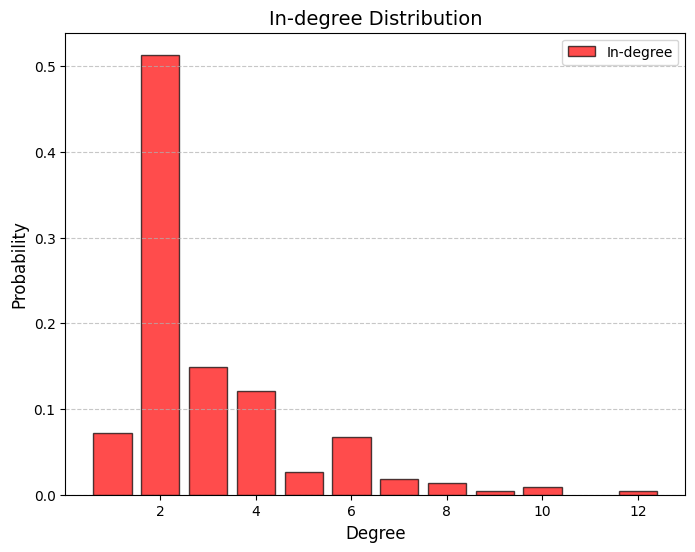

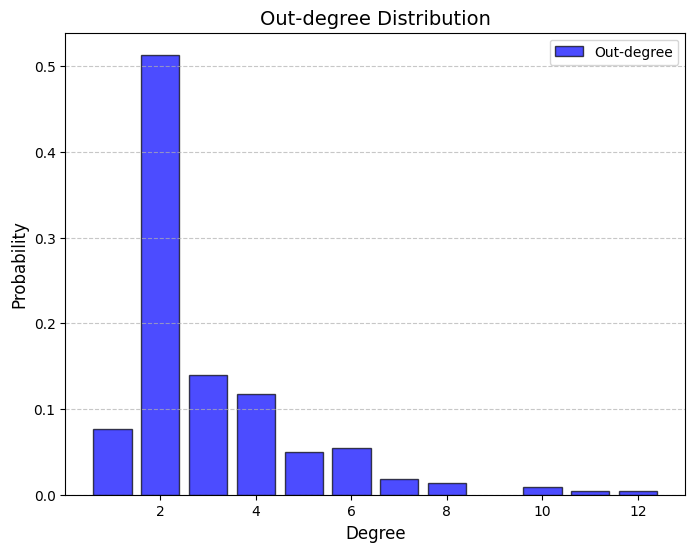

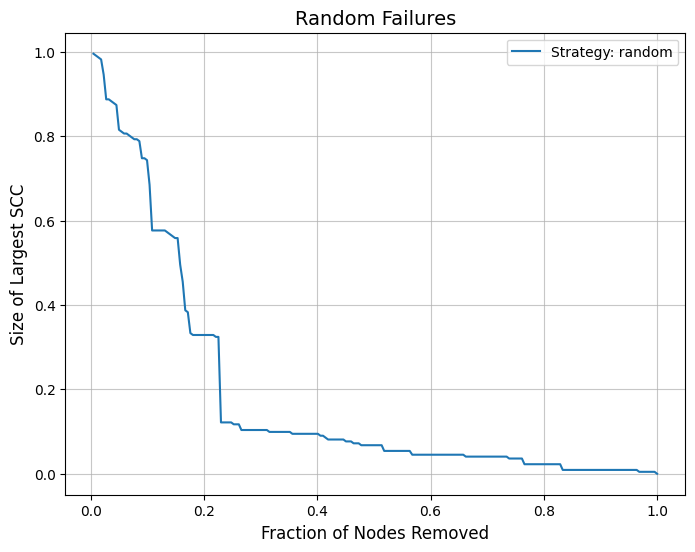

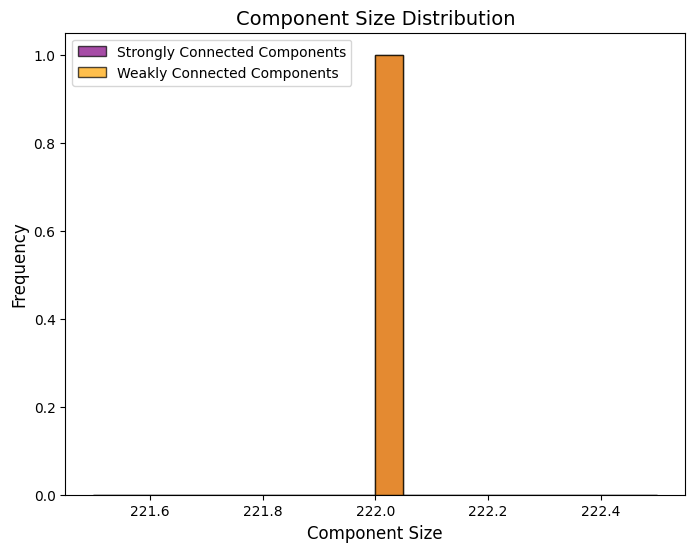

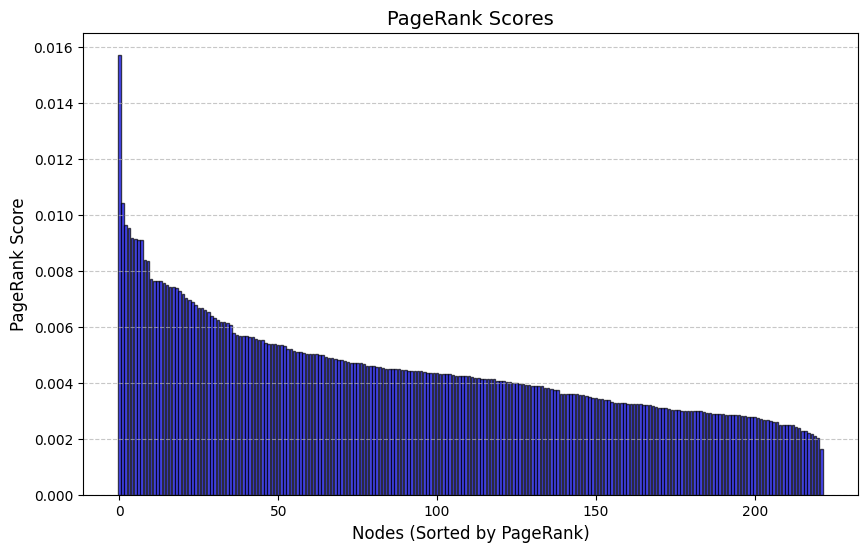

Top 10 nodes by PageRank:
Node Dhaka: 0.0157
Node Parbatipur: 0.0104
Node Bhanga: 0.0097
Node Natore: 0.0095
Node Bhairab_Bazar: 0.0092
Node Rajshahi: 0.0091
Node Jamalpur_Town: 0.0091
Node Feni: 0.0091
Node Kaunia: 0.0084
Node Laksam: 0.0084


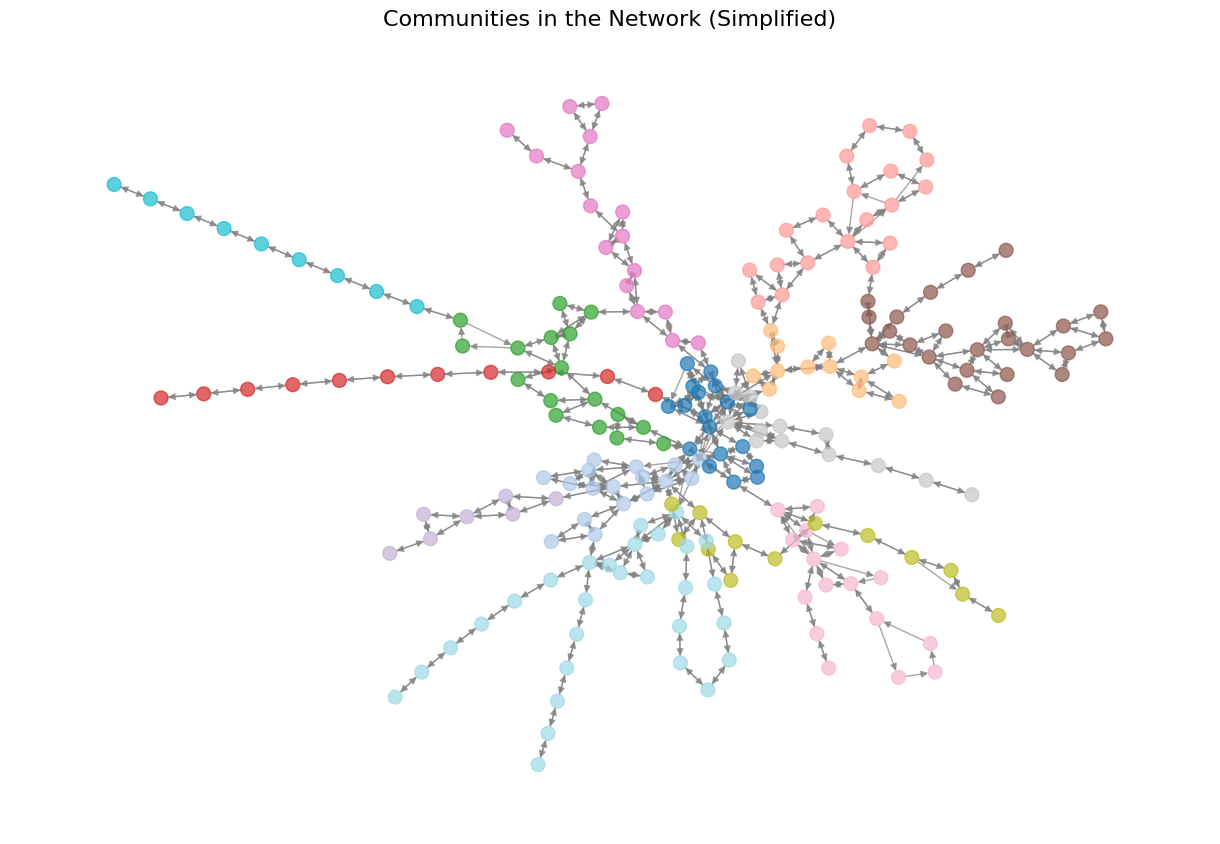

In [132]:
G = loadGraph('train_network.gexf')
plot_degree_distribution_directed(G)
plot_giant_component_vs_node_removal_directed(G, "random", "Random Failures")
analyze_connected_components(G)
pagerank_scores = calculate_pagerank(G)
print("Top 10 nodes by PageRank:")
for node, score in sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"Node {node}: {score:.4f}")
    
partition = detect_communities_directed(G)
plot_large_communities(G, partition)


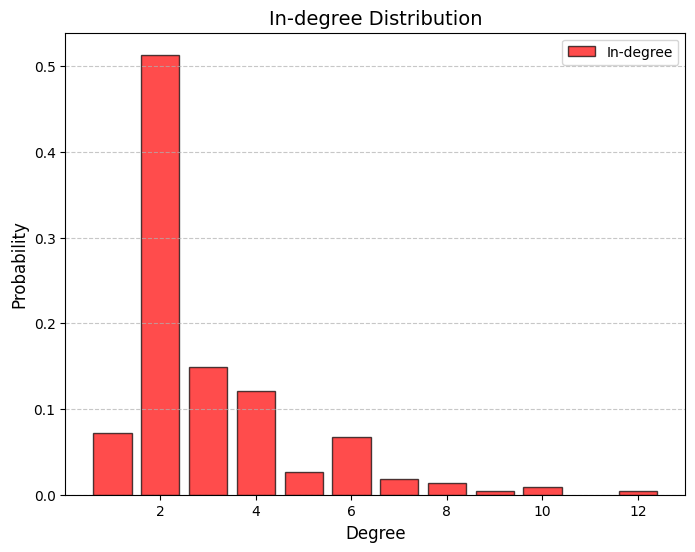

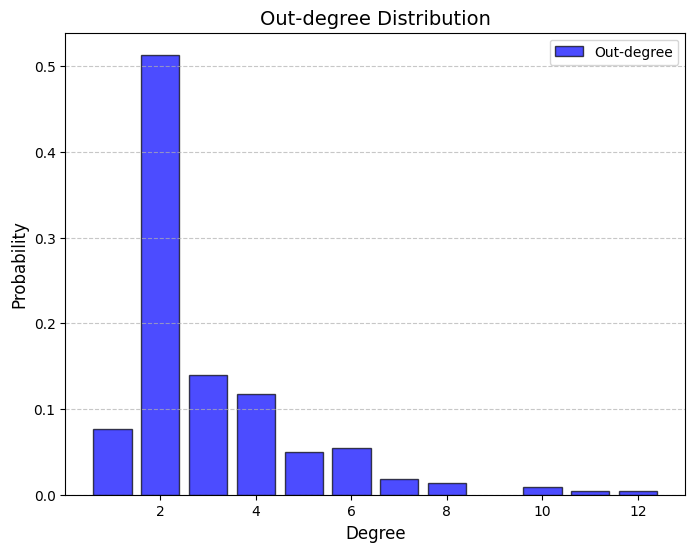

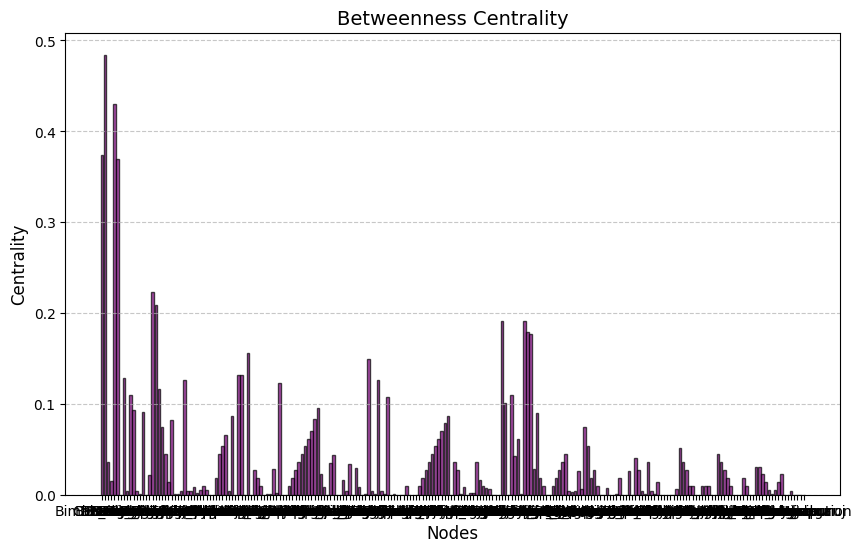

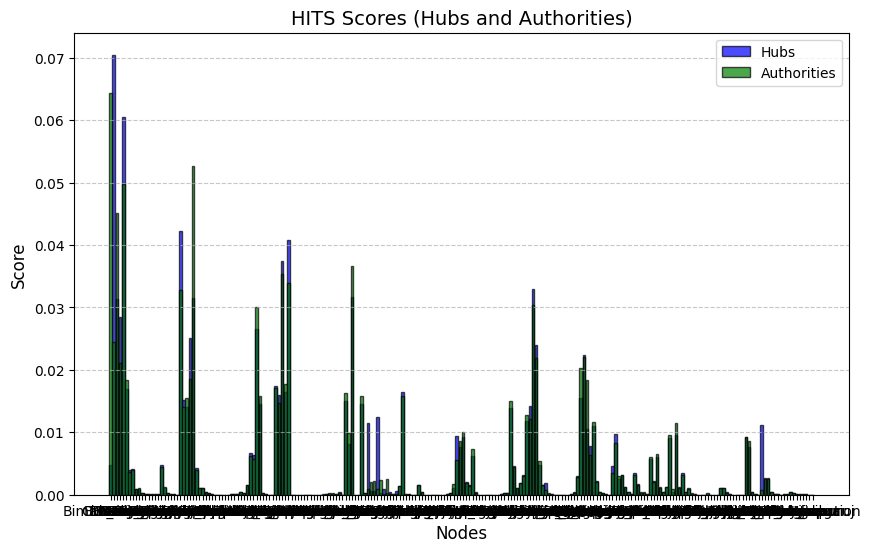

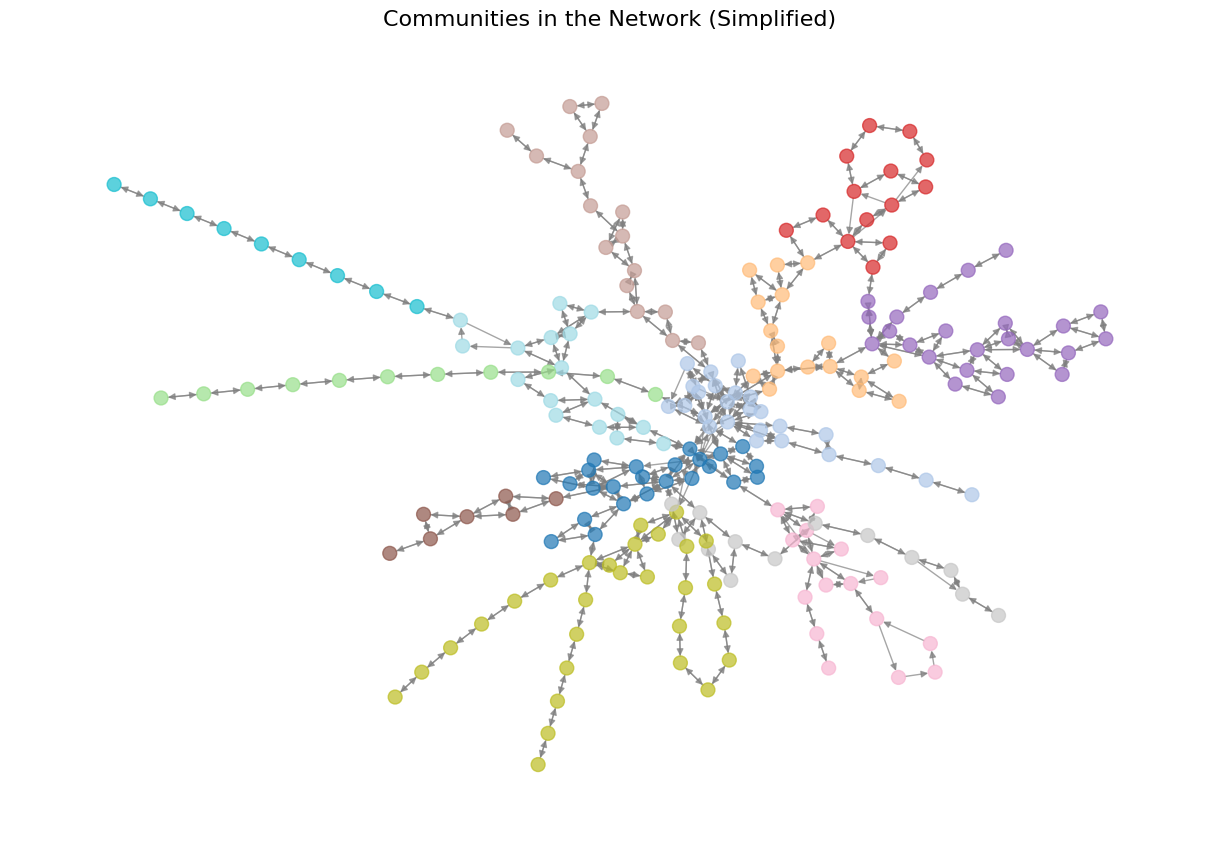

In [133]:
G = loadGraph('train_network.gexf')
plot_degree_distribution_directed(G)
centralities = analyze_centralities(G)
hubs, authorities = calculate_hits(G)
diameter_ecc = graph_diameter_eccentricity(G)
partition = detect_communities_directed(G)
plot_large_communities(G, partition)

Node degrees: {'Dhaka': 16, 'Biman_Bandar': 18, 'BBSetu_E': 15, 'Chatmohar': 10, 'Natore': 21, 'Santahar': 14, 'Talora': 4, 'Bogura': 8, 'Sonatola': 6, 'Bonar_Para': 10, 'Gaibandha': 8, 'Bamondanga': 4, 'Pirgacha': 4, 'Kaunia': 12, 'Kurigram': 4, 'Rangpur': 6, 'Joypurhat': 12, 'Parbatipur': 16, 'Dinajpur': 12, 'Pirganj': 12, 'Thakurgaon_Road': 12, 'B Sirajul Islam': 6, 'Joydebpur': 15, 'Tangail': 6, 'SH M Monsur Ali': 7, 'Ullapara': 9, 'Ishwardi Bypass': 14, 'Akkelpur': 6, 'Panchbibi': 6, 'Birampur': 8, 'Fulbari': 4, 'Chirirbandar': 8, 'Setabganj': 8, 'Ruhia': 6, 'Kismat': 6, 'Khulna': 4, 'Noapara': 6, 'Jashore': 6, 'Mubarakganj': 4, 'Kotchandpur': 8, 'Darshana_Halt': 6, 'Chuadanga': 8, 'Alamdanga': 4, 'Poradaha': 10, 'Bheramara': 8, 'Pakshi': 4, 'Ishwardi': 12, 'Ahsanganj': 6, 'Saidpur': 4, 'Nilphamari': 4, 'Domar': 4, 'Chilahati': 2, 'Jamtail': 8, 'Boral_Bridge': 7, 'Abdulpur': 14, 'Arani': 8, 'Rajshahi': 19, 'Daulatpur': 4, 'Gobra': 2, 'Borashi': 4, 'Gopalganj': 4, 'Chandradighalia'

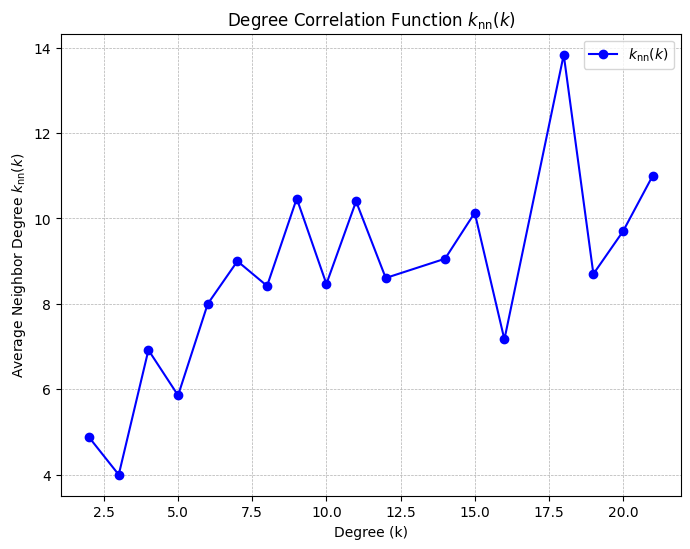

Completed 10000 swaps successfully.
Node degrees: {'Dhaka': 16, 'Biman_Bandar': 18, 'BBSetu_E': 15, 'Chatmohar': 10, 'Natore': 21, 'Santahar': 14, 'Talora': 4, 'Bogura': 8, 'Sonatola': 6, 'Bonar_Para': 10, 'Gaibandha': 8, 'Bamondanga': 4, 'Pirgacha': 4, 'Kaunia': 12, 'Kurigram': 4, 'Rangpur': 6, 'Joypurhat': 12, 'Parbatipur': 16, 'Dinajpur': 12, 'Pirganj': 12, 'Thakurgaon_Road': 12, 'B Sirajul Islam': 6, 'Joydebpur': 15, 'Tangail': 6, 'SH M Monsur Ali': 7, 'Ullapara': 9, 'Ishwardi Bypass': 14, 'Akkelpur': 6, 'Panchbibi': 6, 'Birampur': 8, 'Fulbari': 4, 'Chirirbandar': 8, 'Setabganj': 8, 'Ruhia': 6, 'Kismat': 6, 'Khulna': 4, 'Noapara': 6, 'Jashore': 6, 'Mubarakganj': 4, 'Kotchandpur': 8, 'Darshana_Halt': 6, 'Chuadanga': 8, 'Alamdanga': 4, 'Poradaha': 10, 'Bheramara': 8, 'Pakshi': 4, 'Ishwardi': 12, 'Ahsanganj': 6, 'Saidpur': 4, 'Nilphamari': 4, 'Domar': 4, 'Chilahati': 2, 'Jamtail': 8, 'Boral_Bridge': 7, 'Abdulpur': 14, 'Arani': 8, 'Rajshahi': 19, 'Daulatpur': 4, 'Gobra': 2, 'Borashi': 

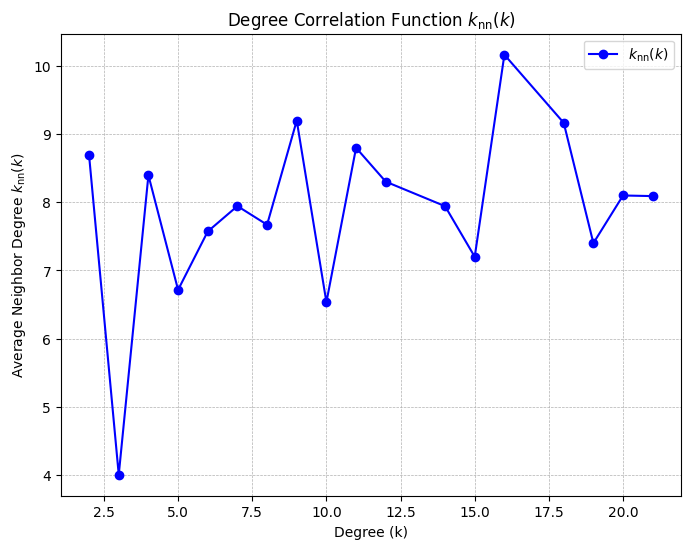

In [134]:
knn = calculate_knn_with_debug(G)
plot_knn(knn)
G_randomized = degree_preserving_randomization(G, 10000)
knn_randomized = calculate_knn_with_debug(G_randomized)
plot_knn(knn_randomized)

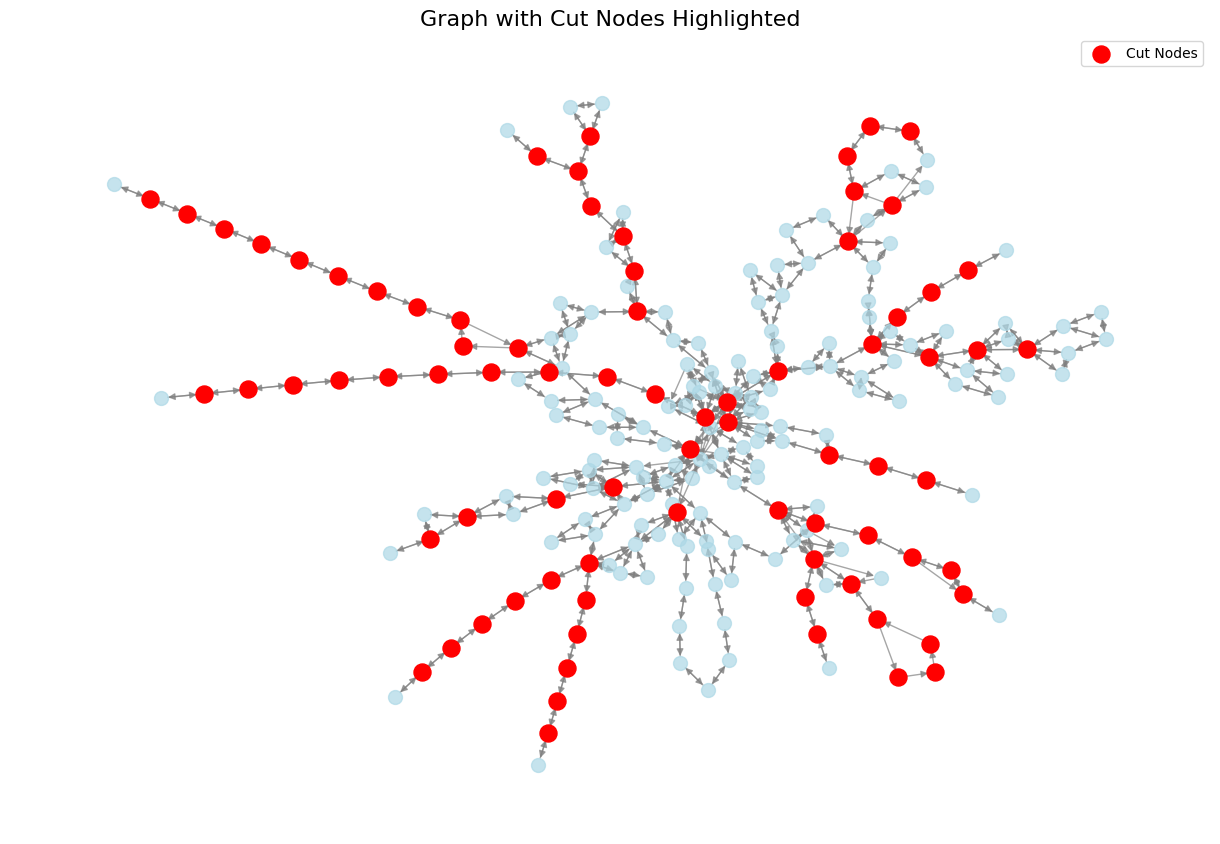

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


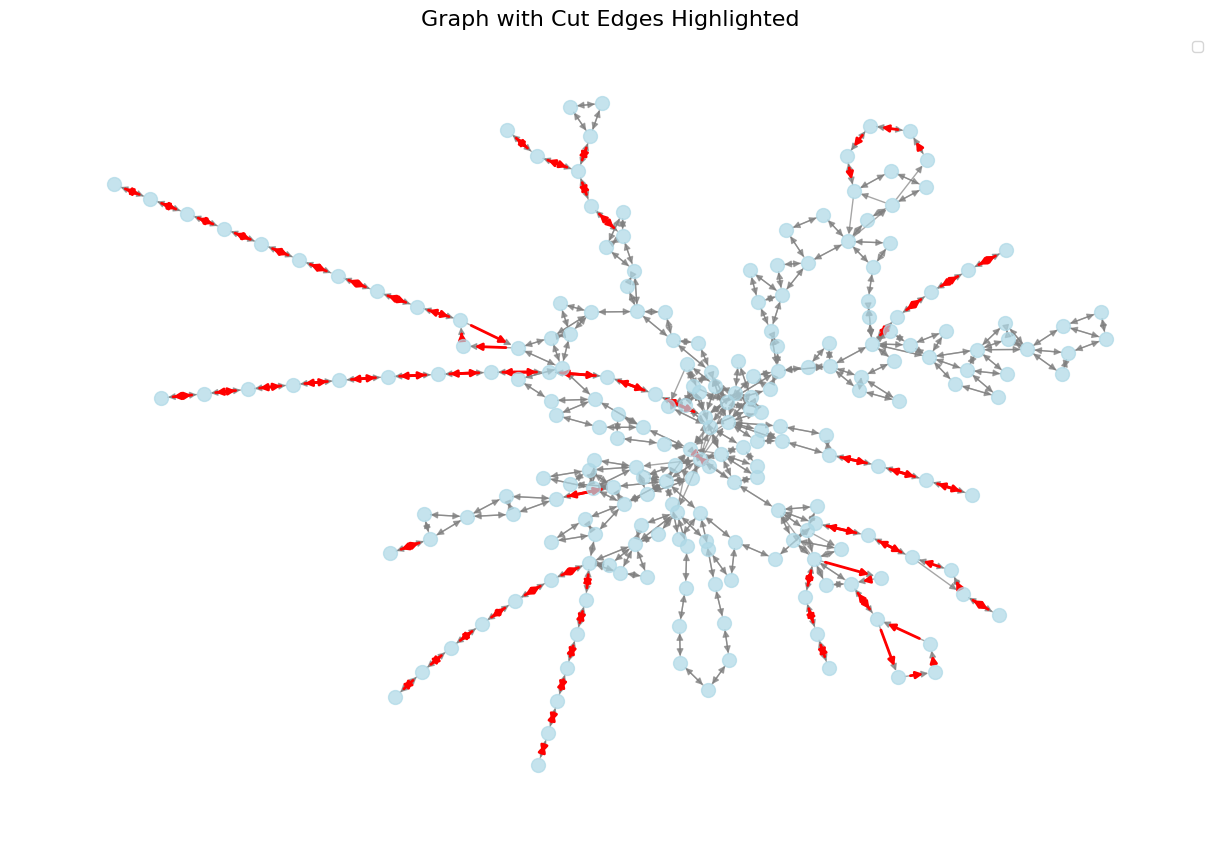

In [141]:
cut_nodes = find_cut_nodes_directed(G)
plot_cut_nodes_directed(G, cut_nodes)
cut_edges = find_cut_edges_directed(G)
plot_cut_edges_directed(G, cut_edges)

C:\Users\User\AppData\Local\Temp\ipykernel_21276\3365247744.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("viridis", num_sccs)


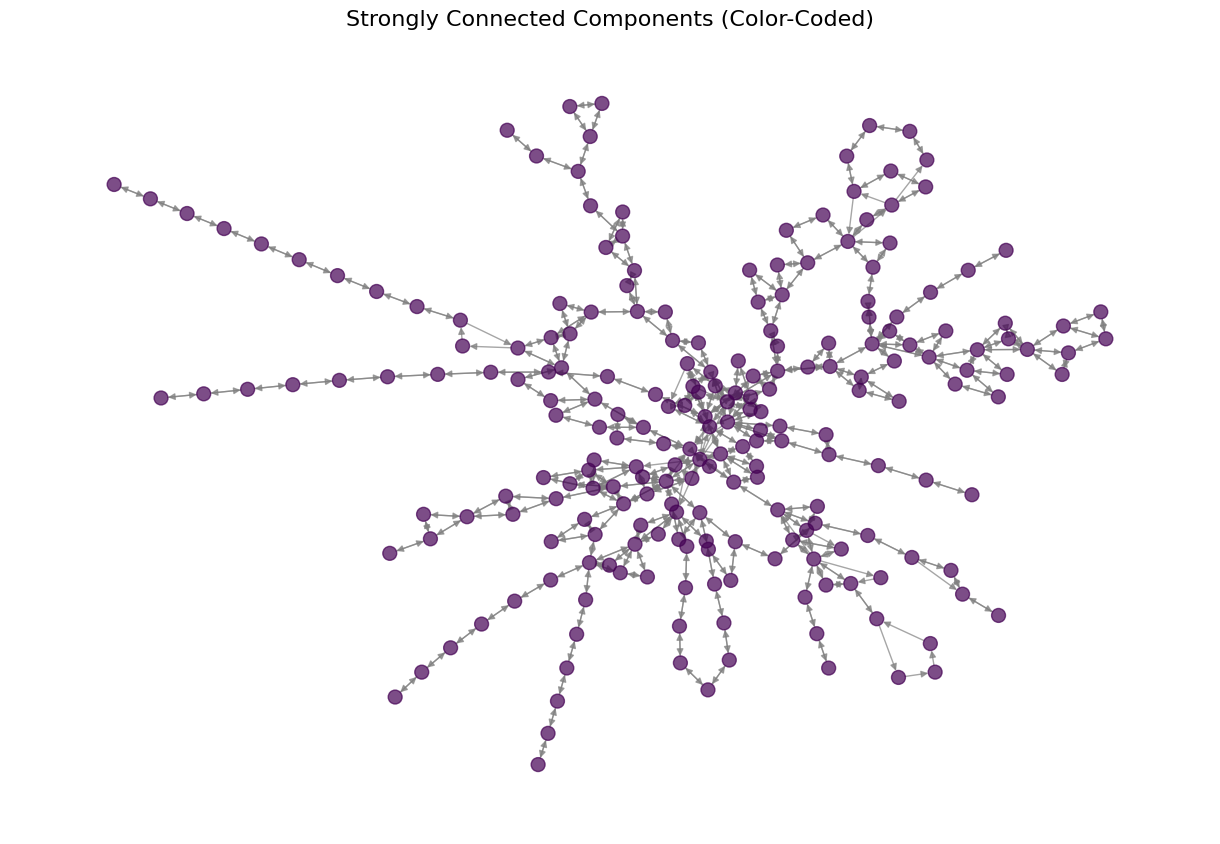

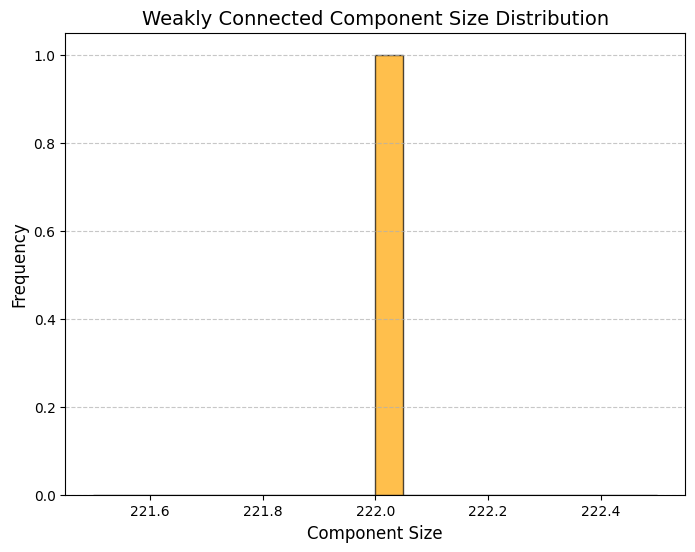

In [143]:
import matplotlib.cm as cm

plot_strongly_connected_components(G)
weak_component_sizes = analyze_weakly_connected_components(G)